# Imports

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
import h5py
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.optimizers import SGD
import random

%matplotlib inline

TensorFlow 2.x selected.


# Clone data

In [0]:
!git clone https://Ahmed-Nasser@bitbucket.org/Ahmed-Nasser/deeplearningdata.git

Cloning into 'deeplearningdata'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
cd deeplearningdata/

/content/deeplearningdata


# Loading data and Normalization

In [0]:
def load_dataset():
    path_to_train = "assignment3_train.h5"
    path_to_test = "assignment3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    return train_x, train_y, test_x, test_y

In [0]:
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

In [0]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)
    

def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)


# Testing models

In [0]:
def test_model(model, model_name, epochs=15, print_summary=True, plot_results=True):
    train_x, train_y, test_x, test_y = preprocess_data()

    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, random_state = 3,test_size=0.1)

    # TODO Try different optimizers, optimizers hyperparameters, losses
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    if (print_summary):
        model.summary()

    hist = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), verbose=1, epochs=epochs, batch_size=32)
    preds = model.evaluate(test_x, test_y, batch_size=32, verbose=1, sample_weight=None)

    print ("Testing Loss = " + str(preds[0]))
    print ("Testing Accuracy = " + str(preds[1]))

    if(plot_results):
        plot_loss(hist, model_name)
        plot_accuracy(hist, model_name)
    return model

# Freeze

In [0]:
# TODO redefine this faulty freeze layers method to perform as you studied in the lecture
def freeze(model, number_of_freezed_layers):
    layers = model.layers
    freezed=[]
    if number_of_freezed_layers < len(layers):
      while(len(freezed) < number_of_freezed_layers):
        freezed.append(random.choice(layers))
    else:
      freezed = layers

    # Randomly choose layer to freeze
    for layer in freezed:
      layer.trainable = False

    return model


# CNN ARCHITECTURE

In [0]:
def test_CNN(input_shape,epochs=10, print_summary=True, plot_results=True, model_name="CNN"):
    # TODO Call test_model from here with your defined CNN Model
    cnn_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(24, (3,3) ,activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(36, (3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Flatten(), # To flatten the image input
      tf.keras.layers.Dense(input_shape[0]*input_shape[1]*input_shape[2], activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    test_model(cnn_model,model_name,epochs,print_summary,plot_results)

# RESNET50

In [0]:
def test_Resnet(input_size,pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="ResNet"):

    if(pretrained):
        model_name = "Pretrained " + model_name
        # TODO define ResNet pretrained model
        base_model = applications.ResNet50(weights='imagenet',input_shape=input_size,include_top=False)
    else:
        model_name = "Untrained " + model_name
        # TODO define Untrained Resnet model
        base_model = applications.ResNet50(weights=None,input_shape=input_size,include_top=False)

    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    # TODO define the top of your model (the output layers)
    resnet_model = tf.keras.Sequential()
    resnet_model.add(base_model)
    resnet_model.add(Flatten())
    # resnet_model.add(Dense(512, activation='relu'))
    # resnet_model.add(Dense(1, activation='sigmoid'))
    resnet_model.add(Dropout(0.5))
    resnet_model.add(Dense(1, activation='sigmoid'))

    test_model(resnet_model, model_name, epochs, print_summary, plot_results)


# VGG16

In [0]:
def test_VGG(input_size,pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="VGG"):


    if(pretrained):
        model_name = "Pretrained " + model_name
        # TODO define VGG pretrained model
        base_model = applications.VGG16(weights='imagenet',input_shape=input_size,include_top=False)
        # add_model = tf.keras.Sequential()
        # add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
        # add_model.add(Dense(256, activation='relu'))
        # add_model.add(Dense(1, activation='sigmoid'))

        # vgg_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    else:
        model_name = "Untrained " + model_name
        # TODO define Untrained VGG model
        base_model = applications.VGG16(weights=None,input_shape=input_size,include_top=False)
        #vgg_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    # TODO define the top of your model (the output layers)
    vgg_model = tf.keras.Sequential()
    vgg_model.add(base_model)
    vgg_model.add(layers.Flatten())
    vgg_model.add(layers.Dense(512, activation='relu'))
    vgg_model.add(layers.Dense(1, activation='sigmoid')) 

    test_model(vgg_model, model_name, epochs, print_summary, plot_results)

# Main

In [0]:
train_x, train_y, test_x, test_y = preprocess_data()
input_shape = train_x.shape[1:]

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


# Testing

# CNN

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 24)        672       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 36)        7812      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 36)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_3 (Den

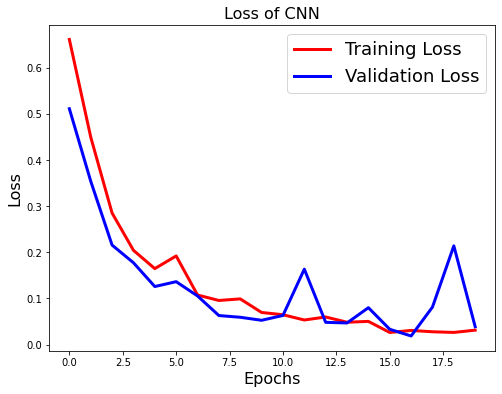

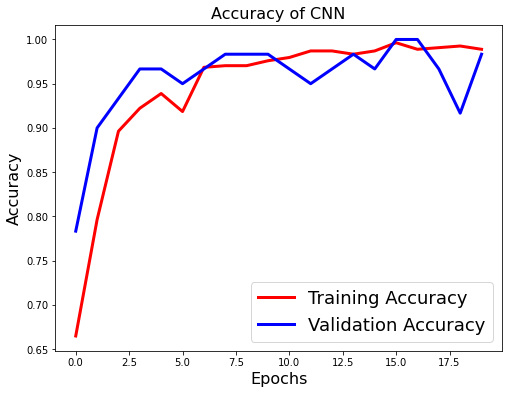

In [0]:
model = test_CNN(input_shape,20)

# VGG (PRETRAINED WEIGHTS)

58892288/58889256 [==============================] - 6s 0us/step
number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 15,764,289
Trainable params: 15,764,289
Non-trainable params: 0
_________________________________________________________________
T

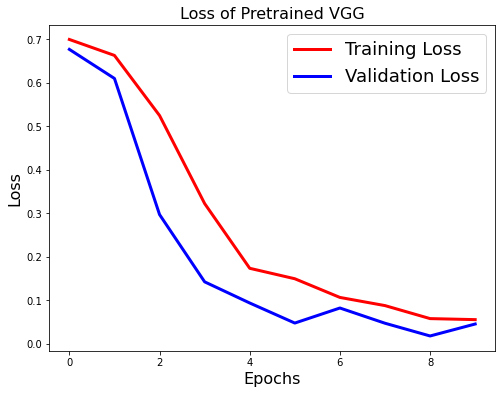

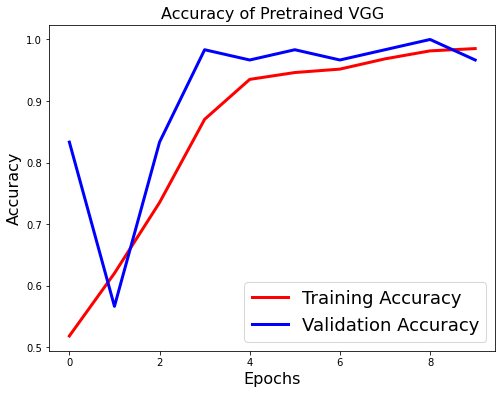

In [0]:
test_VGG(input_shape)

# VGG (WITHOUT PRETRAINED WEIGHTS)

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 15,764,289
Trainable params: 15,764,289
Non-trainable params: 0
_________________________________________________________________
Train on 540 samples, validate on 60 samples
Epoch 1/10
540/540 [=

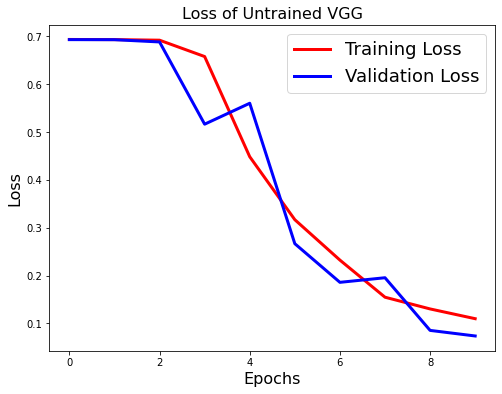

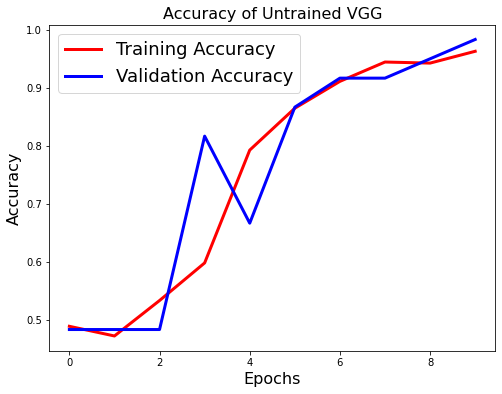

In [0]:
test_VGG(input_shape,False)

# RESNET50 (PRETRAINED WEIGHTS)

94773248/94765736 [==============================] - 1s 0us/step
number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 23,595,905
Trainable params: 23,542,785
Non-trainable params: 53,120
________________________________________________________________

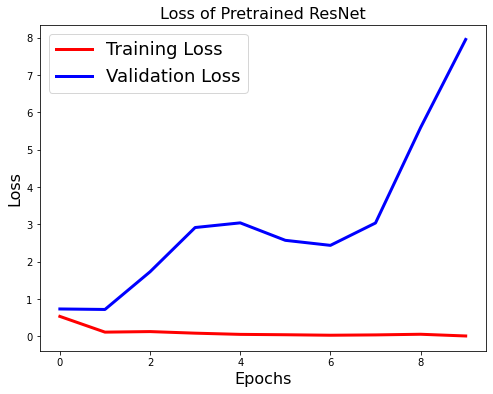

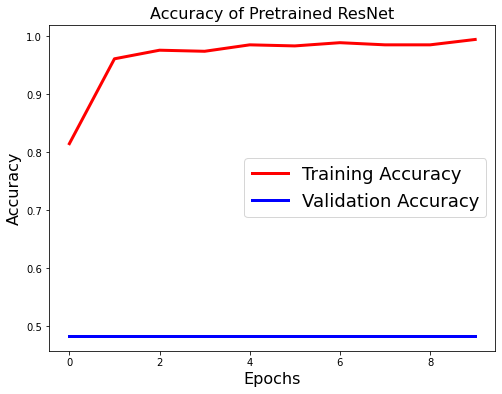

In [0]:
test_Resnet(input_shape)

# RESNET50 (WITHOUT PRETRAINED WEIGHTS)

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8193      
Total params: 23,595,905
Trainable params: 23,542,785
Non-trainable params: 53,120
_________________________________________________________________
Train on 540 samples, validate on 60 samples
Epoch 1/10
540/5

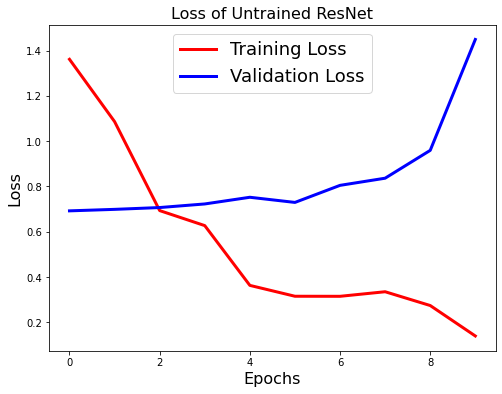

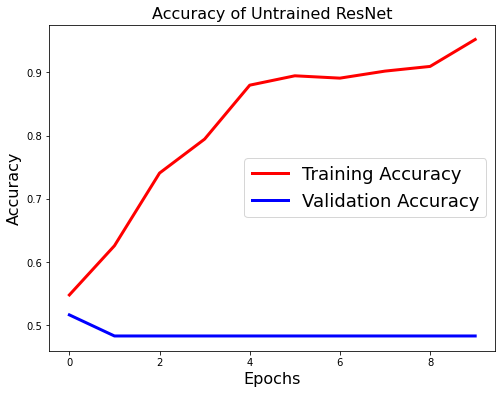

In [0]:
test_Resnet(input_shape,False)

# Testing freezing in VGG

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 15,764,289
Trainable params: 14,584,129
Non-trainable params: 1,180,160
_________________________________________________________________
Train on 540 samples, validate on 60 samples
Epoch 1/10
54

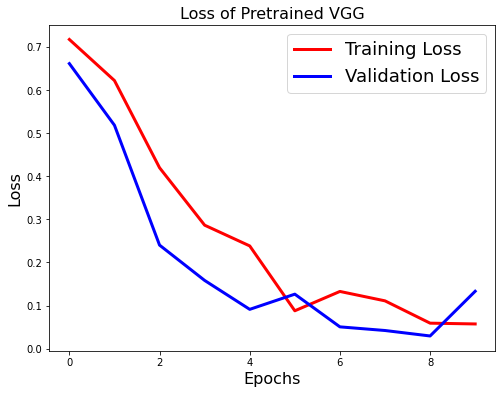

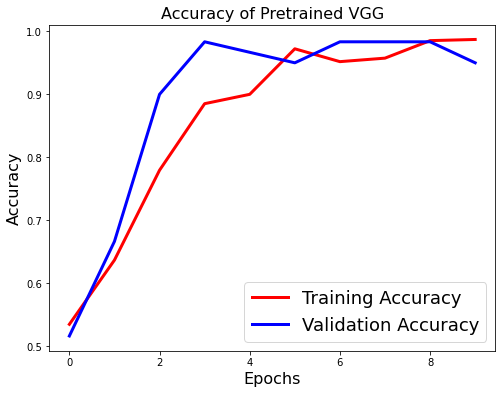

In [0]:
test_VGG(input_shape,True,True,2)

# Testing freezing in RESNET

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8193      
Total params: 23,595,905
Trainable params: 23,522,113
Non-trainable params: 73,792
_________________________________________________________________
Train on 540 samples, validate on 60 samples
Epoch 1/10
540/5

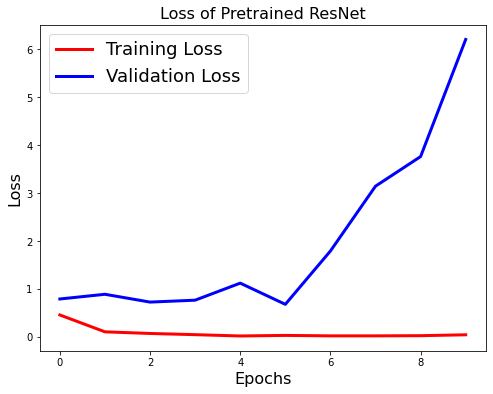

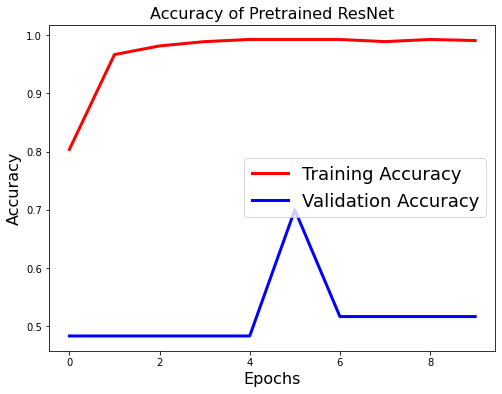

In [0]:
test_Resnet(input_shape,True,True,3)